# Tree and Boosting method
## Tree

Data download:

In [136]:
set.seed(123)
data <- read.csv(file.path("..", "data", "training_data.csv"))
data <- na.omit(data)
data$PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

In [137]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]
dim(data)

[1]  708 3029

Division into train and test set. 

In [138]:
idx <- sample(nrow(data), 4*nrow(data)/5)

#matrix
train.x <- data[idx,]
train.x$PL <- NULL
train.x <- as.matrix(train.x)
train.y <- data$PL[idx]

test.x <- data[-idx,]
test.x$PL <- NULL
test.x <- as.matrix(test.x)
test.y <- data$PL[-idx]

#data.frame
train.set = data[idx,]
test.set = data[-idx,]


First, we create a simple tree on the train set to observe a first analysis in order to improve it. 

In [4]:
library(tree)

tree.pl <- tree(PL ~ ., data = train.set)
summary(tree.pl)


Regression tree:
tree(formula = PL ~ ., data = train.set)
Variables actually used in tree construction:
 [1] "Mor13m"         "R6s."           "E1i"            "Mor07s"        
 [5] "HATS6p"         "TDB08p"         "Mor24m"         "R1e"           
 [9] "R2v."           "E2u"            "SpMaxA_AEA.ed." "H_Dz.Z."       
[13] "HATS7e"         "H0p"            "P1m"            "L3u"           
[17] "RDF060u"        "GATS8m"         "HATS5e"         "SpDiam_AEA.dm."
[21] "Mor25v"         "HATS4v"         "HATSe"         
Number of terminal nodes:  24 
Residual mean deviance:  294.1 = 159400 / 542 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-45.5500 -10.6500  -0.9479   0.0000  11.7100  45.9000 

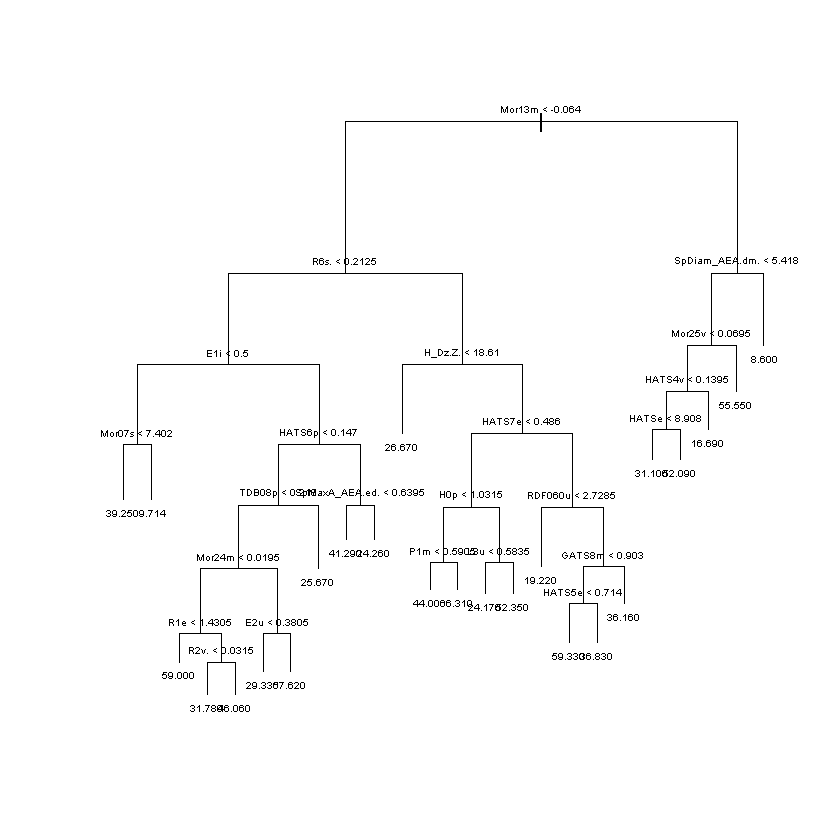

In [5]:
plot(tree.pl)
text(tree.pl, pretty=0, cex=0.5)

This tree has 24 nodes. 

Calculation of the mean squared error: 

In [6]:
y.pred <- predict(tree.pl, newdata = test.set)
paste('The MSE of this tree is', mean((y.pred-test.y)^2)) 

[1] "The MSE of this tree is 559.818139028532"

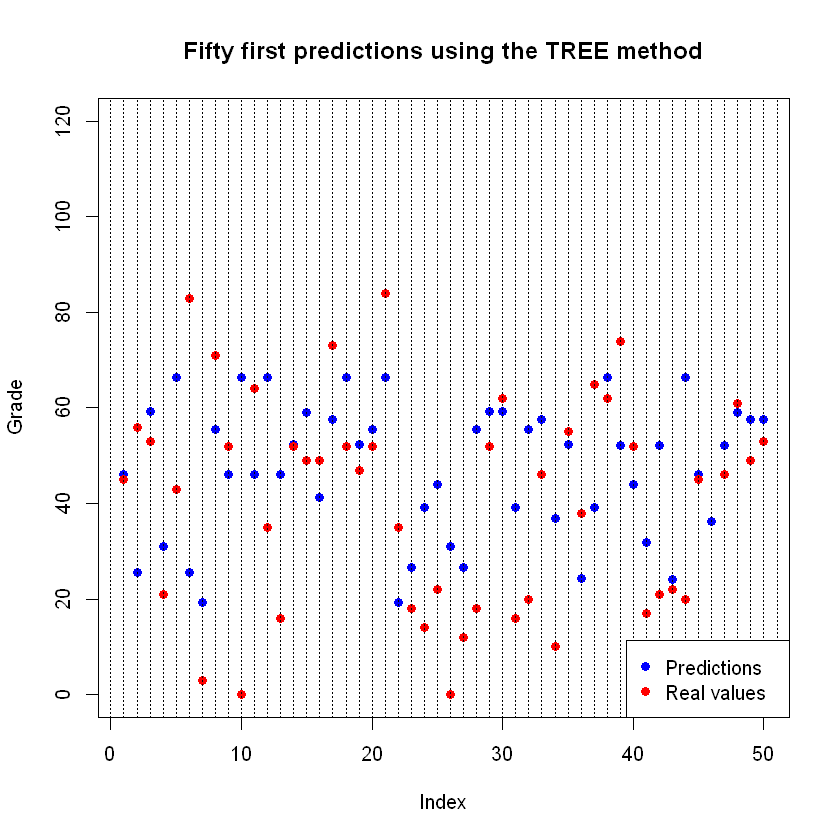

In [7]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using the TREE method')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The MSE is better than directly applied a linear regression. However, the lasso regularization gives us better results. 

Therefore, we can now perform a cross-validation test to optimize and find a better tree finding the best size. It is also a solution to avoid overfitting.

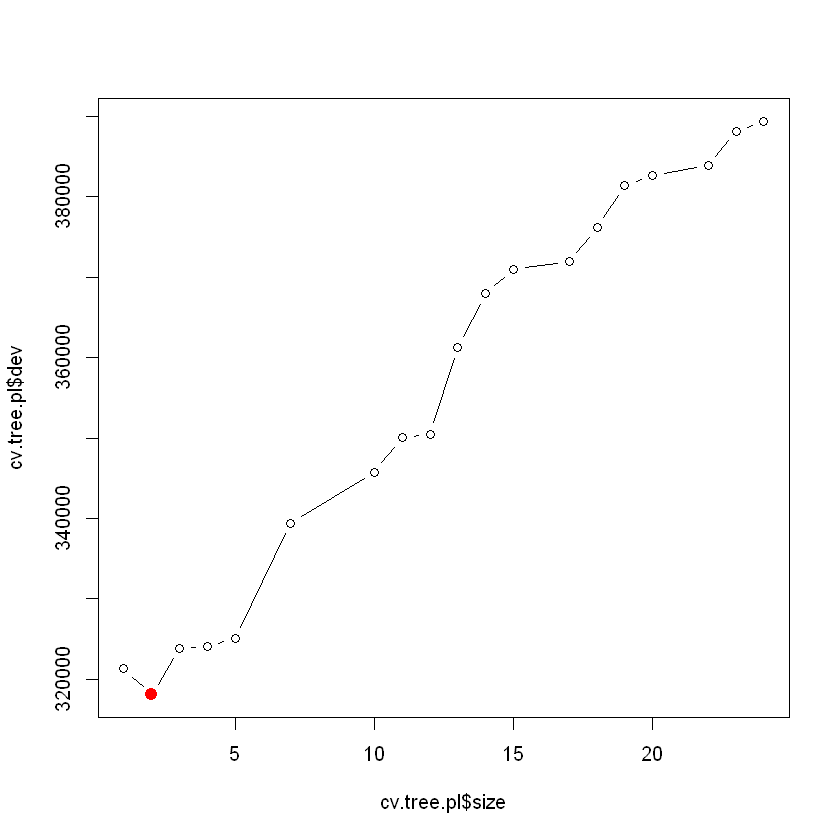

In [8]:
set.seed(8)
cv.tree.pl <- cv.tree(tree.pl)
plot(cv.tree.pl$size, cv.tree.pl$dev, type='b')
tree.min <- which.min(cv.tree.pl$dev)
points(cv.tree.pl$size[tree.min], cv.tree.pl$dev[tree.min], col='red', cex=2, pch=20)

We find here the best size is 2, selected by CV. 

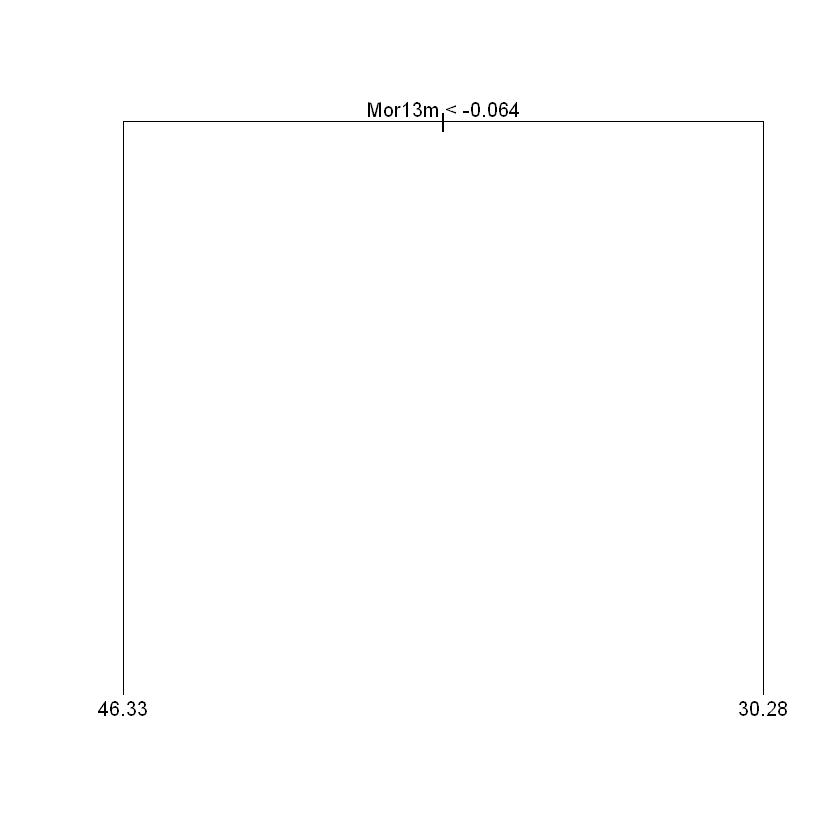

In [9]:
prune.tree.pl <- prune.tree(tree.pl, best = cv.tree.pl$size[tree.min])
plot(prune.tree.pl)
text(prune.tree.pl, pretty=0)

In [10]:
y.pred <- predict(prune.tree.pl, newdata = test.set)
paste('The MSE of the prune tree is', mean((y.pred-test.y)^2)) 

[1] "The MSE of the prune tree is 457.287375192267"

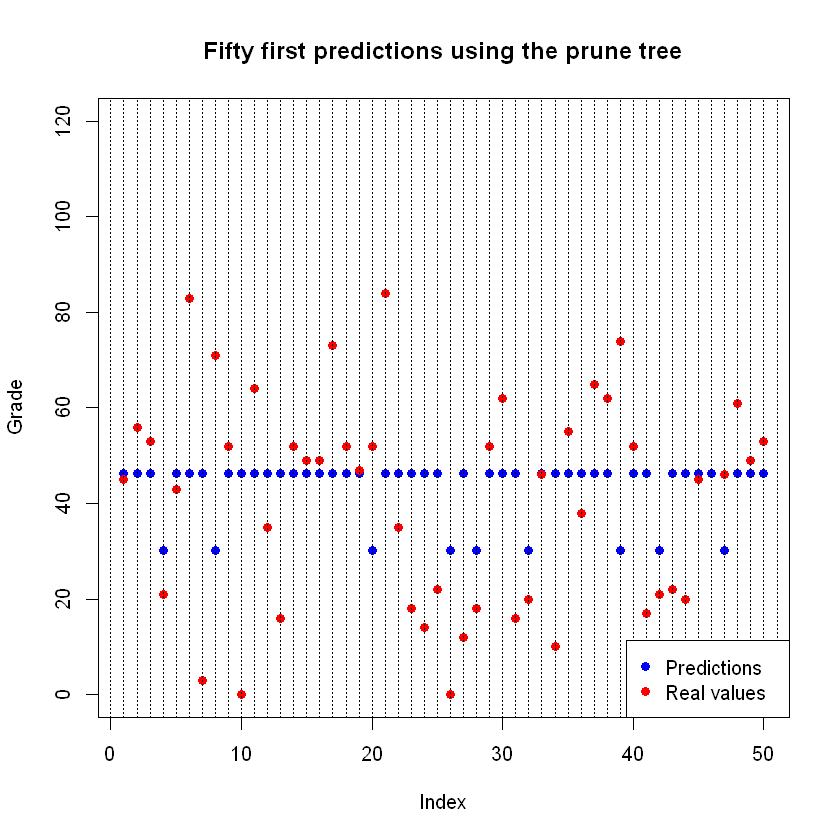

In [14]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using the prune tree')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

By calculation, we find a lower MSE. However, when we plot the prediction values, we observe they are too concentrated at approximately 50. The model is underfitted.


## Boosting 

The boosting method should well improve the results.  

In [15]:
library(xgboost)

By setting at 1000 trees, we want to find the best shrinkage value to minimise the mean squared error. 

In [17]:
set.seed(1)
pows <- seq(-3.5, -0.2, by = 0.1)
lambdas <- 10^pows

train.err <- rep(NA, length(lambdas))
test.err <- rep(NA, length(lambdas))

for (i in 1:length(lambdas)) {
    boost.pl <- xgboost(train.x, label=train.y, eta=lambdas[i], objective="reg:squarederror", max.depth=3, nrounds=1000, verbose = 0)
    pred.train <- predict(boost.pl, train.x)
    pred.test <- predict(boost.pl, test.x)
    train.err[i] <- mean((pred.train - train.y)^2)
    test.err[i] <- mean((pred.test - test.y)^2)
}

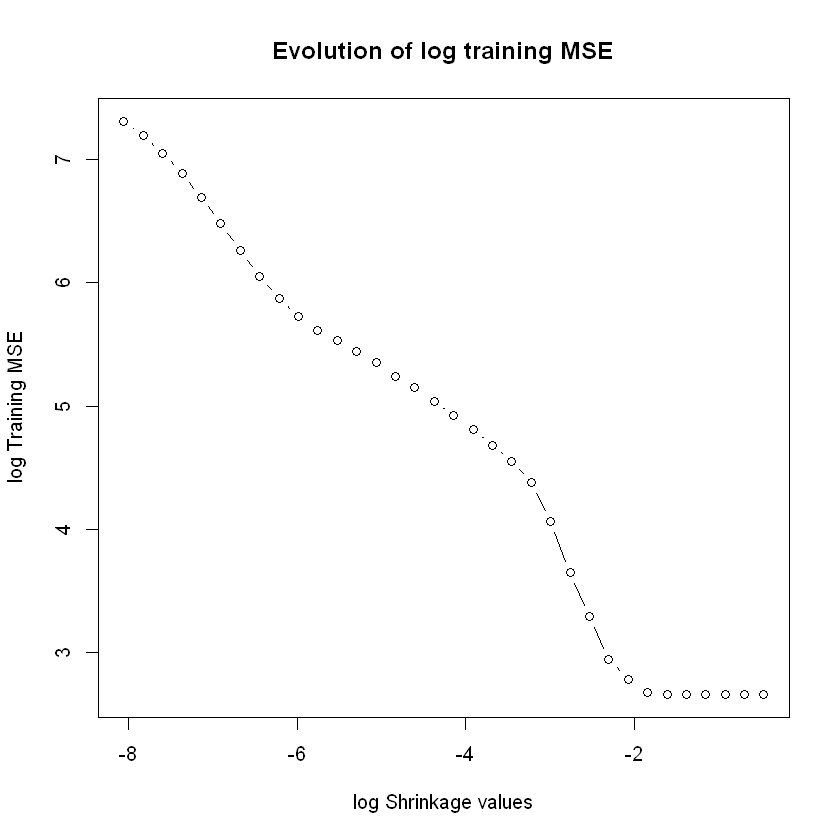

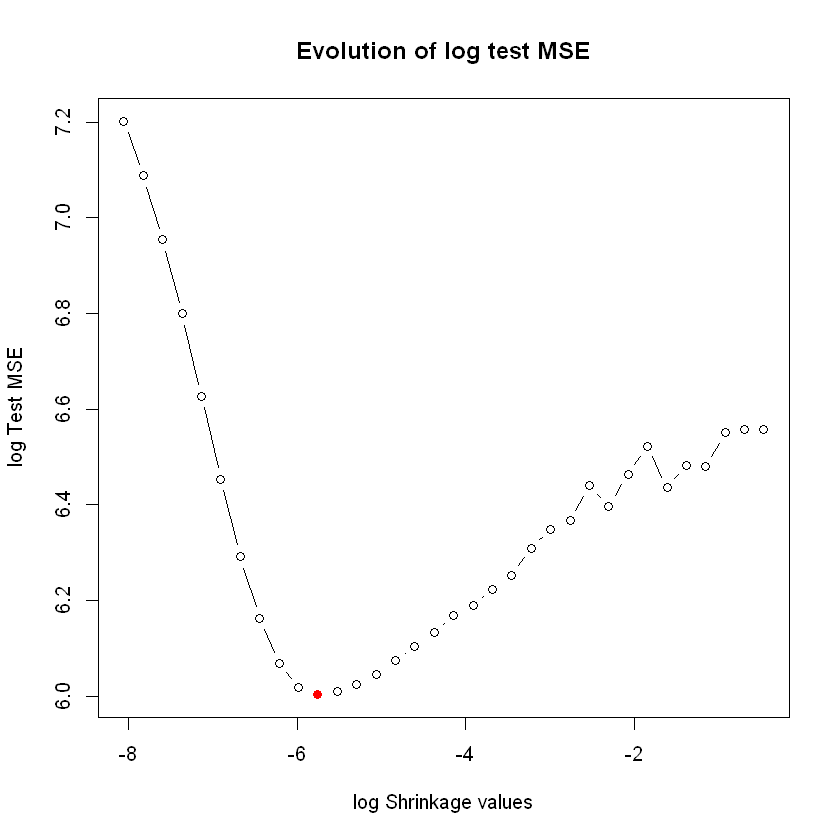

In [23]:
#training MSE
plot(log(lambdas), log(train.err), type="b", xlab="log Shrinkage values", ylab="log Training MSE")
title('Evolution of log training MSE')

#Test MSE
plot(log(lambdas), log(test.err), type="b", xlab="log Shrinkage values", ylab="log Test MSE")
points(log(lambdas[which.min(test.err)]), log(min(test.err)), col='red', pch=19)
title('Evolution of log test MSE')

In [24]:
paste('The minimum test error is', min(test.err))
paste('The optimal shrinkage is', lambdas[which.min(test.err)])

[1] "The minimum test error is 404.595091315944"

[1] "The optimal shrinkage is 0.00316227766016838"

We evaluate the boosting model with different possible $\lambda$ in order to avoid overfit or underfit of the prediction data.

Here, the model we found above and its prediction plot:

In [26]:
set.seed(1)
boost.pl <- xgboost(train.x, label=train.y, eta=lambdas[which.min(test.err)], objective="reg:squarederror", max.depth=3, nrounds=1000, verbose = 0)
y.pred <- predict(boost.pl, test.x)
test.error <- mean((y.pred - test.y)^2) 

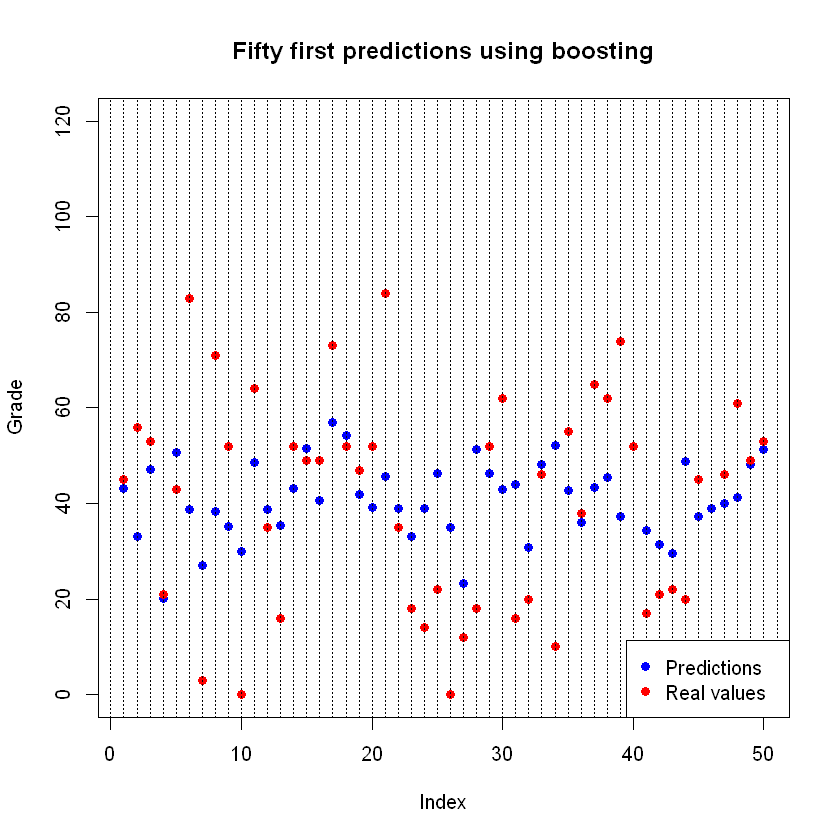

In [27]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using boosting')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

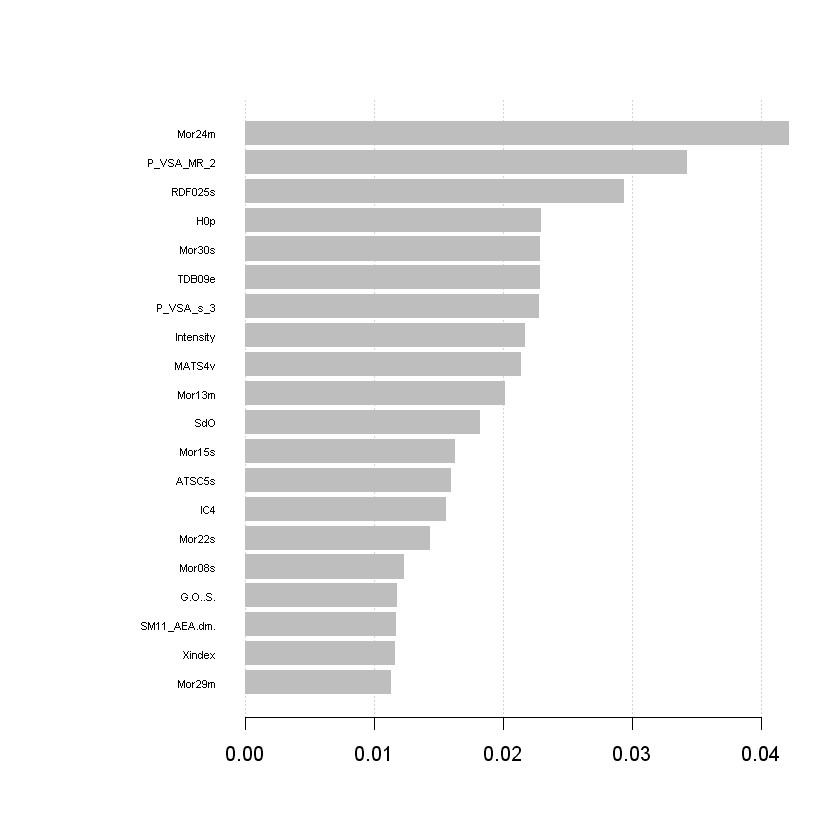

In [28]:
importance <- xgb.importance(model=boost.pl)
xgb.plot.importance(importance_matrix = importance, top_n = 20)

Here, the first 20 most important predictors are plotted.

To have another tuning, we can create a hyper_grid which contains different values of $\lambda$ and maximal size 'max_depth'. Then, we perform a cross-validation:

In [42]:
# create hyperparameter grid
hyper_grid <- expand.grid(
  eta = c(.001, .005, .01, .1),
  max_depth = c(1, 3, 5, 7)  
)

In [43]:
library(keras)

In [44]:
# grid search 
for(i in 1:nrow(hyper_grid)) {
  
  # create parameter list
  params <- list(
    eta = hyper_grid$eta[i],
    max_depth = hyper_grid$max_depth[i],
    objective = 'reg:squarederror'
  )
  
  # reproducibility
  set.seed(123)
  
  # train model
  xgb.tune <- xgb.cv(
    params = params,
    data = as.matrix(train.set),
    label = train.set$PL,
    nrounds = 5000,
    nfold = 10,
    verbose = 0,               # silent,
    early_stopping_rounds = 10 # stop if no improvement for 10 consecutive trees
  )
# add min training error and trees to grid
  hyper_grid$optimal_trees[i] <- which.min(xgb.tune$evaluation_log$test_rmse_mean)
  hyper_grid$min_RMSE[i] <- min(xgb.tune$evaluation_log$test_rmse_mean)
}
  

In [57]:
hyper_grid %>%
  dplyr::arrange(min_RMSE)

eta,max_depth,optimal_trees,min_RMSE
<dbl>,<dbl>,<int>,<dbl>
0.010,1,2939,0.1699272
0.005,1,4999,0.1717617
0.010,3,2020,0.2146240
0.005,3,3862,0.2170836
0.010,7,2018,0.2303244
0.010,5,2018,0.2313938
0.005,5,3910,0.2325731
0.005,7,3906,0.2331014
0.100,3,144,0.2605220


For simplicity, we assume the first one: 


In [79]:
set.seed(123)
boost.pl <- xgboost(train.x, label=train.y, eta=0.01, objective="reg:squarederror", max.depth=1, nrounds=2939, verbose = 0)
y.pred <- predict(boost.pl, test.x)
test.error <- mean((y.pred - test.y)^2) 
paste('MSE =', test.error)

[1] "MSE = 423.140222385201"

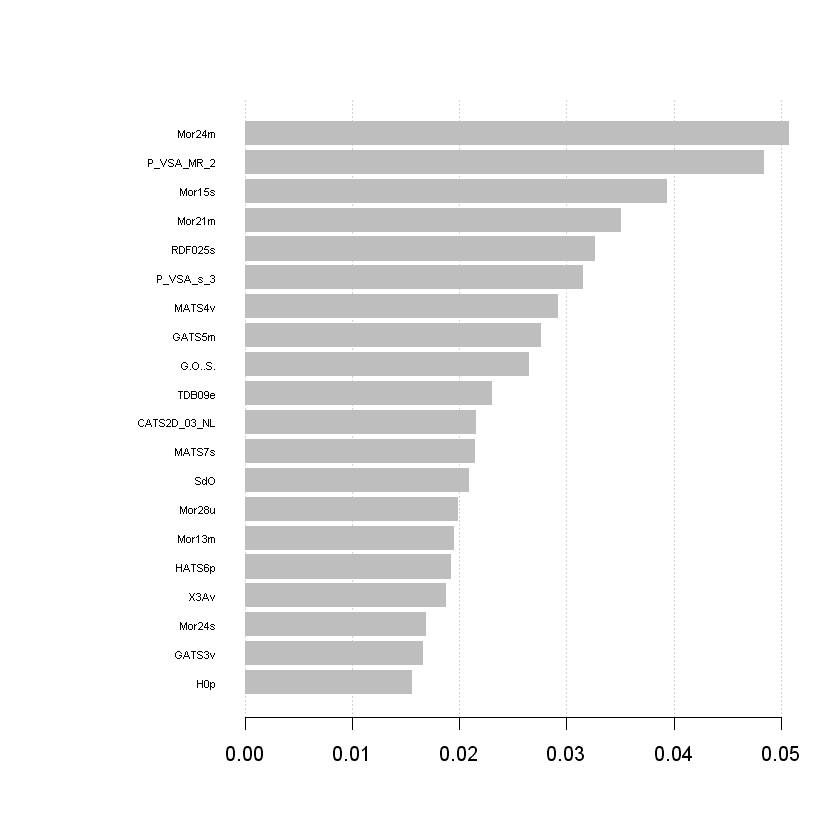

In [80]:
importance <- xgb.importance(model=boost.pl)
xgb.plot.importance(importance_matrix = importance, top_n = 20)

The importance graph shows the same first predictor: mor24m. 

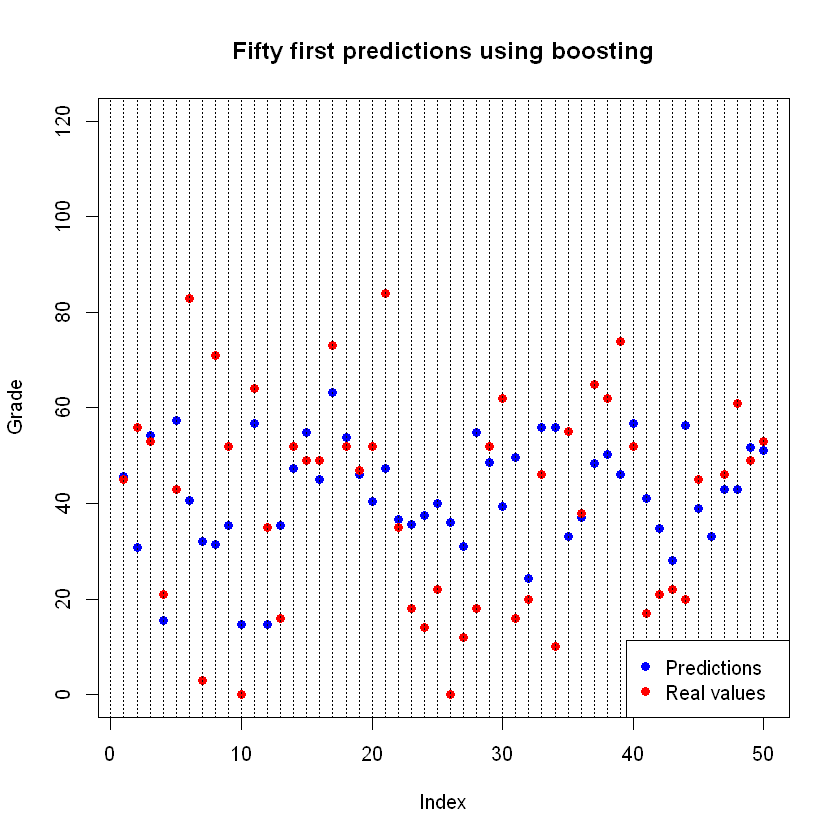

In [81]:
plot(y.pred[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using boosting')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The predictions have a bit more variance that the other predictions from boosting with the parameters: $\lambda=0.00316227766016838$, $d=3$ and $nrounds = 1000$. However, the MSE is slightly higher.

### Random Forest
Comparison with the bagging and random forest: 

In [82]:
library(randomForest)
set.seed(123)
bag <- randomForest(PL ~ ., data=train.set, mtry = ncol(train.x), ntree = 1000)
pred.bag <- predict(bag, newdata=test.x)
mean((pred.bag-test.y)^2)

[1] 435.3679

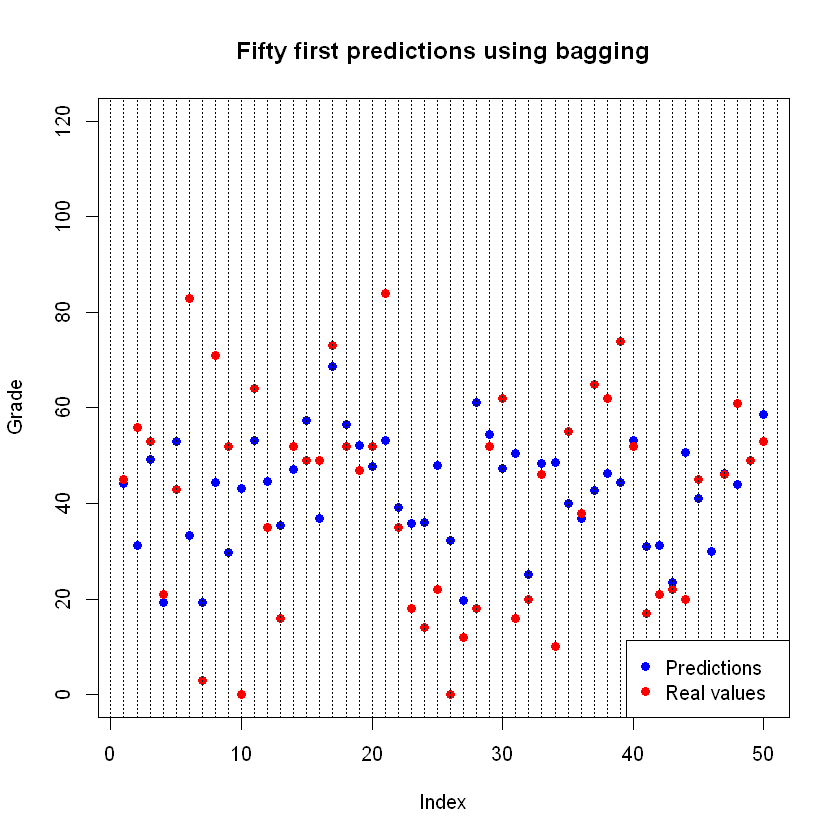

In [83]:
plot(pred.bag[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using bagging')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

Random forest: $m \approx\frac{p}{3}$, the default value for regression model.

In [84]:
set.seed(123)
bag <- randomForest(PL ~ ., data=train.set, ntree = 1000)
pred.rf <- predict(bag, newdata=test.x)
paste('The MSE of random forest model is', mean((pred.rf-test.y)^2))

[1] "The MSE of random forest model is 443.680661473317"

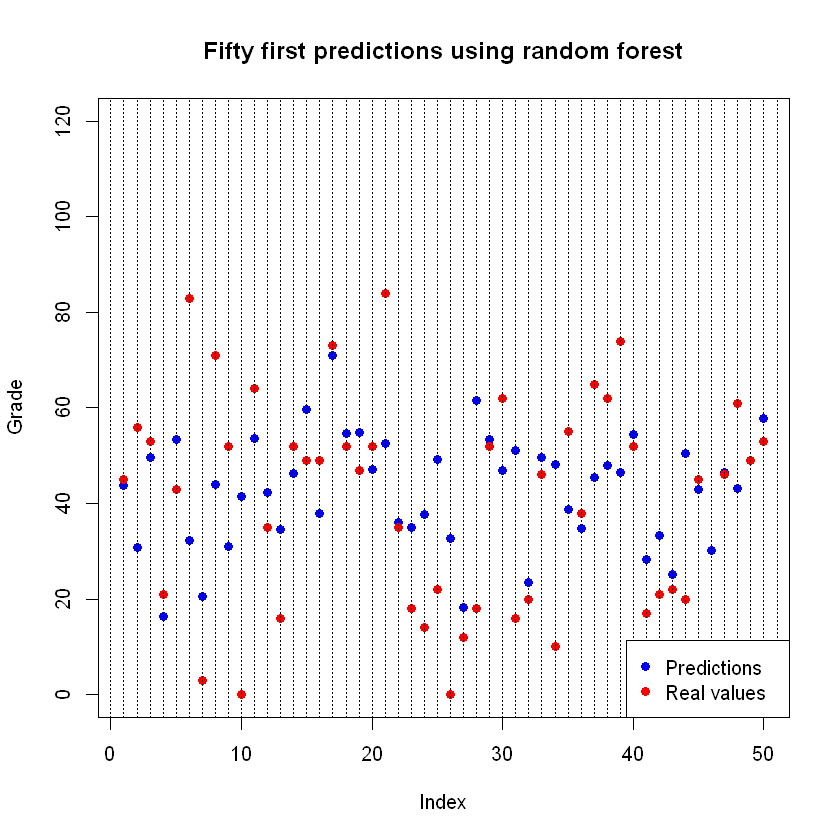

In [85]:
plot(pred.rf[1:50], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:50], col = 'red', pch = 19)
title('Fifty first predictions using random forest')
for(i in seq(0, 100, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The boosting method gives us a better MSE than bagging and the random forest models.